<a href="https://colab.research.google.com/github/Shriyatha/Active-meta-learning/blob/main/CNP_SiNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Sine Function Data

In [ ]:
import numpy as np
import torch

def generate_sine_task(num_points=50):
    """Generates a sine function task with random amplitude, frequency, and phase shift."""
    A = np.random.uniform(0.5, 2.0)  # Amplitude
    B = np.random.uniform(0.5, 2.0)  # Frequency
    C = np.random.uniform(0, np.pi)  # Phase shift

    x = np.random.uniform(-5, 5, num_points)  # Random x values
    y = A * np.sin(B * x + C)  # Compute sine function
    return x, y

# Split Data into Context & Target Sets

In [ ]:
def get_context_target(x, y, context_ratio=0.5):
    """Splits data into context and target sets."""
    num_context = int(len(x) * context_ratio)
    indices = np.random.permutation(len(x))

    context_x, context_y = x[indices[:num_context]], y[indices[:num_context]]
    target_x, target_y = x[indices[num_context:]], y[indices[num_context:]]

    return context_x, context_y, target_x, target_y


# Define the CNP Model

In [ ]:
import torch
import torch.nn as nn

class CNPEncoder(nn.Module):
    def __init__(self, sizes):
        super(CNPEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        """
        Encode training set as one vector representation.

        Args:
            context_x: batch_size x set_size x feature_dim
            context_y: batch_size x set_size x 1

        Returns:
            representation: batch_size x representation_size
        """
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, feature_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)

        for linear in self.linears[:-1]:
            x = torch.relu(linear(x))
        x = self.linears[-1](x)

        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)  # Aggregation (Mean Pooling)
        return representation


class CNPDecoder(nn.Module):
    def __init__(self, sizes):
        super(CNPDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        """
        Takes representation of the context set and target_x to predict y.

        Args:
            representation: batch_size x representation_size
            target_x: batch_size x set_size x feature_dim
        Returns:
            Gaussian distribution with predicted mean and std deviation.
        """
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input_data = torch.cat((representation, target_x), dim=-1)

        x = input_data.view(batch_size * set_size, -1)
        for linear in self.linears[:-1]:
            x = torch.relu(linear(x))
        x = self.linears[-1](x)

        out = x.view(batch_size, set_size, -1)
        # The output layer should have 2 units to predict both mu and log_sigma
        # Change the last layer size to 2 in decoder_sizes
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)  # Ensures positive std dev

        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma


class CNP(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(CNP, self).__init__()
        self.encoder = CNPEncoder(encoder_sizes)
        self.decoder = CNPDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        """
        Given (context_x, context_y) and target_x, returns predicted y.

        Args:
            query: Tuple of (context_x, context_y), target_x
            target_y: (Optional) True target values for computing log prob.

        Returns:
            log probability, predicted mean, and std deviation.
        """
        (context_x, context_y), target_x = query
        representation = self.encoder(context_x, context_y)
        dist, mu, sigma = self.decoder(representation, target_x)

        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma


# Training Loop

In [ ]:
import torch.optim as optim

def train_cnp(model, num_training_tasks=5000, eval_interval=500, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    mse_history = []

    for step in range(1, num_training_tasks + 1):
        x, y = generate_sine_task()
        context_x, context_y, target_x, target_y = get_context_target(
            torch.tensor(x).float().unsqueeze(-1),
            torch.tensor(y).float().unsqueeze(-1)
        )

        optimizer.zero_grad()
        log_p, mu, sigma = model(((context_x.unsqueeze(0), context_y.unsqueeze(0)), target_x.unsqueeze(0)), target_y.unsqueeze(0))
        loss = -log_p.mean()
        loss.backward()
        optimizer.step()

        if step % eval_interval == 0:
            mse = evaluate_cnp(model)
            mse_history.append((step, mse))
            print(f"Step {step}: MSE {mse:.4f}")

    return mse_history


# Evaluating and Plotting MSE

In [ ]:
def evaluate_cnp(model):
    loss_fn = nn.MSELoss()
    total_loss = 0.0

    with torch.no_grad():
        for context_x, context_y, target_x, target_y in test_tasks:
            # Pass the data as a query tuple to the model
            # The model returns a tuple: (log_p, mu, sigma)
            _, mu, _ = model(((context_x.unsqueeze(0), context_y.unsqueeze(0)), target_x.unsqueeze(0)))

            # We're interested in mu for the MSE calculation:
            pred_y = mu.squeeze(0)  # Now squeeze is applied to the tensor 'mu'

            total_loss += loss_fn(pred_y, target_y.unsqueeze(0)).item()

    return total_loss / len(test_tasks)

In [ ]:
def create_fixed_sine_test_set():
    test_tasks = []
    for _ in range(100):
        x, y = generate_sine_task()
        context_x, context_y, target_x, target_y = get_context_target(torch.tensor(x).float().unsqueeze(-1),
                                                                      torch.tensor(y).float().unsqueeze(-1))
        test_tasks.append((context_x, context_y, target_x, target_y))
    return test_tasks

test_tasks = create_fixed_sine_test_set()

In [ ]:
import matplotlib.pyplot as plt

def plot_mse_curve(mse_history):
    steps, mse_values = zip(*mse_history)
    plt.plot(steps, mse_values, marker='o')
    plt.xlabel("Number of Training Tasks")
    plt.ylabel("Average MSE")
    plt.title("CNP Performance on Sine Function")
    plt.show()


# Initialize and Train

Step 500: MSE 0.8974
Step 1000: MSE 0.8343
Step 1500: MSE 0.8340
Step 2000: MSE 0.8348
Step 2500: MSE 0.8735
Step 3000: MSE 0.7801
Step 3500: MSE 0.8076
Step 4000: MSE 0.7614
Step 4500: MSE 0.7344
Step 5000: MSE 0.7059


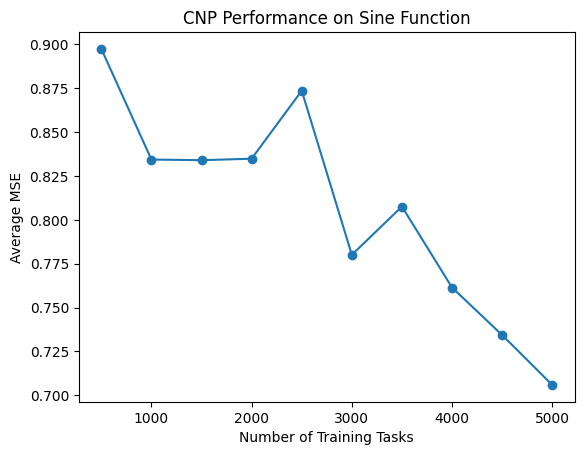

In [ ]:
encoder_sizes = [2, 128, 128]  # Input: (x, y) -> Hidden Layers
decoder_sizes = [128 + 1, 128, 2]  # Input: (Representation + target_x) -> Hidden Layers

cnp_model = CNP(encoder_sizes, decoder_sizes)

mse_history = train_cnp(cnp_model)
plot_mse_curve(mse_history)


2025-03-21 22:58:12, Iteration: 0, test loss: 1.0702828168869019


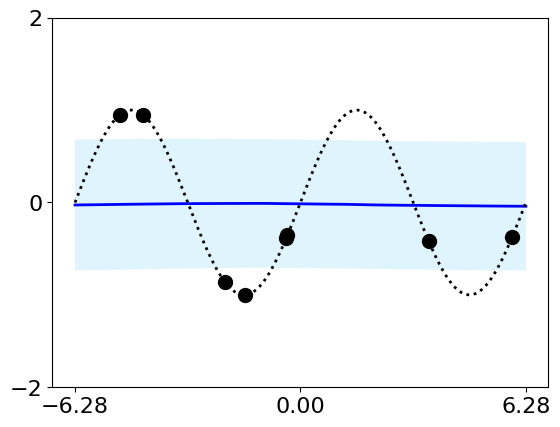

2025-03-21 23:02:41, Iteration: 20000, test loss: -1.380751371383667


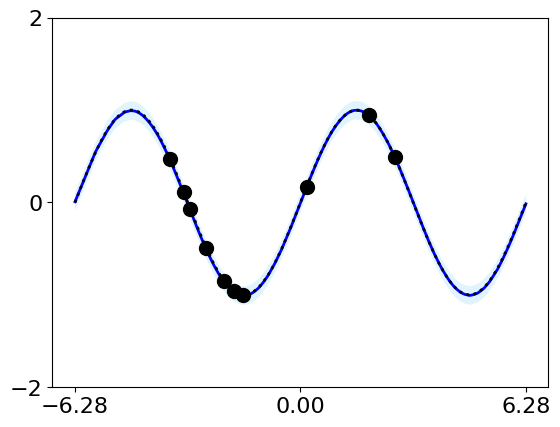

2025-03-21 23:06:56, Iteration: 40000, test loss: -1.3833296298980713


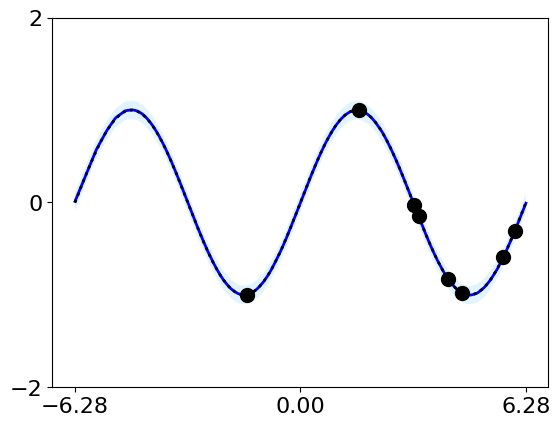

2025-03-21 23:11:23, Iteration: 60000, test loss: -1.383368968963623


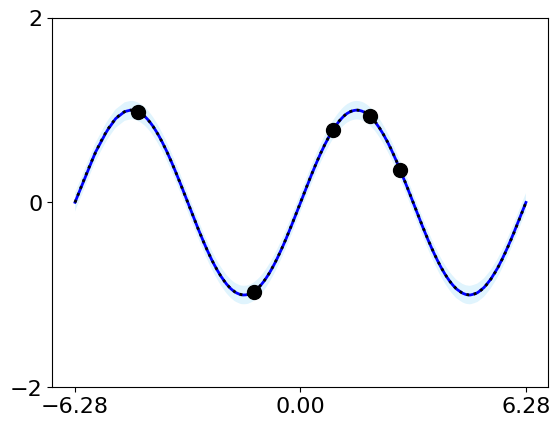

2025-03-21 23:15:54, Iteration: 80000, test loss: -1.3834247589111328


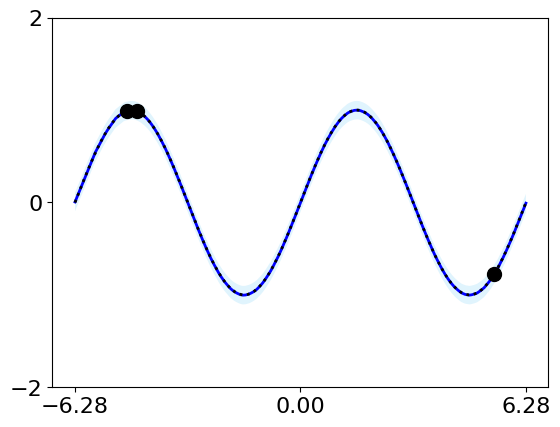

2025-03-21 23:20:26, Iteration: 100000, test loss: -1.3830393552780151


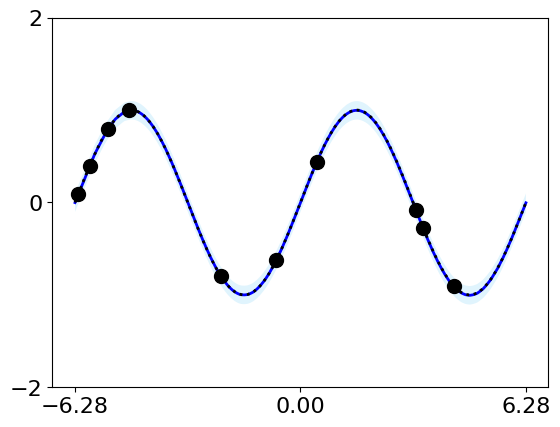

2025-03-21 23:25:00, Iteration: 120000, test loss: -1.3833729028701782


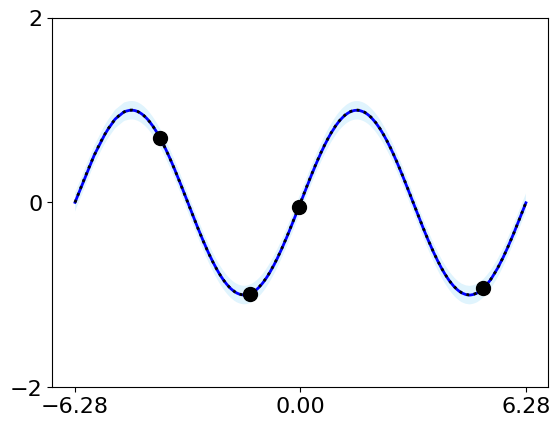

2025-03-21 23:29:33, Iteration: 140000, test loss: -1.3835383653640747


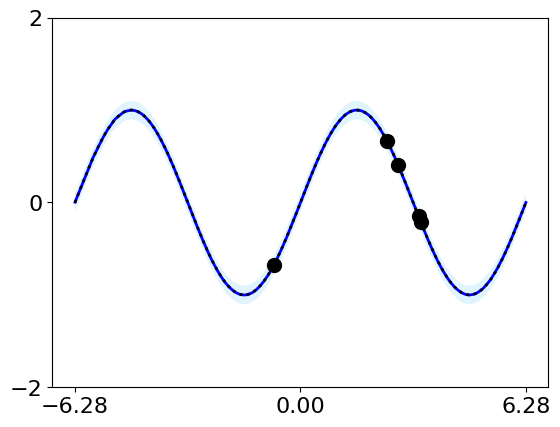

2025-03-21 23:34:07, Iteration: 160000, test loss: -1.3830050230026245


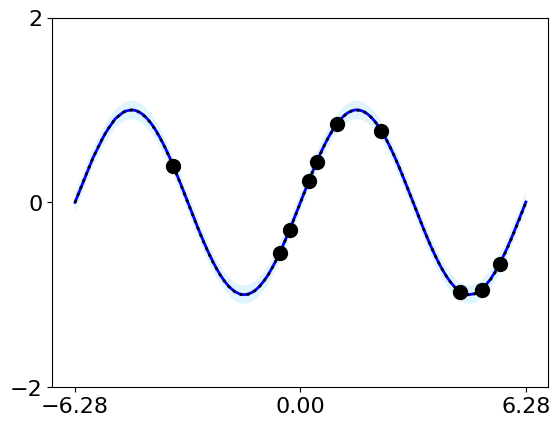

2025-03-21 23:38:45, Iteration: 180000, test loss: -1.383602261543274


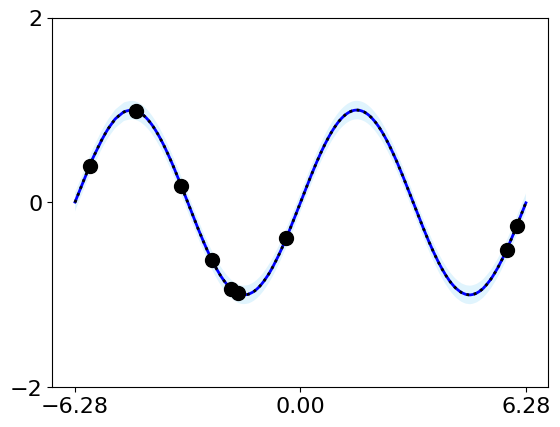

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)


class GPCurvesReader(object):
    """Generates curves using a Gaussian Process (GP).

    Supports vector inputs (x) and vector outputs (y). Kernel is
    mean-squared exponential, using the x-value l2 coordinate distance scaled by
    some factor chosen randomly in a range. Outputs are independent gaussian
    processes.
    """

    def __init__(
        self,
        batch_size,
        max_num_context,
        x_size=1,
        y_size=1,
        l1_scale=0.4,
        sigma_scale=1.0,
        testing=False,
    ):
        """Creates a regression dataset of functions sampled from a GP.

        Args:
          batch_size: An integer.
          max_num_context: The max number of observations in the context.
          x_size: Integer >= 1 for length of "x values" vector.
          y_size: Integer >= 1 for length of "y values" vector.
          l1_scale: Float; typical scale for kernel distance function.
          sigma_scale: Float; typical scale for variance.
          testing: Boolean that indicates whether we are testing. If so there are
              more targets for visualization.
        """
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self._l1_scale = l1_scale
        self._sigma_scale = sigma_scale
        self._testing = testing

    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Applies the Gaussian kernel to generate curve data.

        Args:
          xdata: Tensor with shape `[batch_size, num_total_points, x_size]` with
              the values of the x-axis data.
          l1: Tensor with shape `[batch_size, y_size, x_size]`, the scale
              parameter of the Gaussian kernel.
          sigma_f: Float tensor with shape `[batch_size, y_size]`; the magnitude
              of the std.
          sigma_noise: Float, std of the noise that we add for stability.

        Returns:
          The kernel, a float tensor with shape
          `[batch_size, y_size, num_total_points, num_total_points]`.
        """
        num_total_points = xdata.shape[1]

        # Expand and take the difference
        x1 = xdata.unsqueeze(dim=1)
        x2 = xdata.unsqueeze(dim=2)

        diff = x1 - x2  # [B, num_total_points, num_total_points, x_size]

        # [B, y_size, num_total_points, num_total_points, x_size]
        norm = (diff[:, None, :, :, :] / l1[:, :, None, None, :]) ** 2

        norm = norm.sum(dim=-1)  # [B, data_size, num_total_points, num_total_points]

        # [B, y_size, num_total_points, num_total_points]
        kernel = (sigma_f ** 2)[:, :, None, None] * torch.exp(-0.5 * norm)

        # Add some noise to the diagonal to make the cholesky work.
        kernel += (sigma_noise ** 2) * torch.eye(num_total_points)

        return kernel

    def generate_curves(self):
        """Builds the op delivering the data.

        Generated functions are `float32` with x values between -2 and 2.

        Returns:
          A `CNPRegressionDescription` namedtuple.
        """

        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        # If we are testing we want to have more targets and have them evenly
        # distributed in order to plot the function.
        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target)
            x_values = (
                x_values.unsqueeze(dim=0).repeat([self._batch_size, 1]).unsqueeze(-1)
            )

        # During training the number of target points and their x-positions are
        # selected at random
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (
                torch.rand((self._batch_size, num_total_points, self._x_size)) * 4 - 2
            )  # unif[-2, 2]

        # Set kernel parameters
        l1 = torch.ones(self._batch_size, self._y_size, self._x_size) * self._l1_scale
        sigma_f = torch.ones(self._batch_size, self._y_size) * self._sigma_scale

        # Pass the x_values through the Gaussian kernel
        # [batch_size, y_size, num_total_points, num_total_points]
        kernel = self._gaussian_kernel(x_values, l1, sigma_f)

        # Calculate Cholesky, using double precision for better stability:
        cholesky = torch.linalg.cholesky(kernel.type(torch.DoubleTensor)).type(
            torch.FloatTensor
        )

        # Sample a curve
        # [batch_size, y_size, num_total_points, 1]
        y_values = torch.matmul(
            cholesky, torch.randn(self._batch_size, self._y_size, num_total_points, 1)
        )

        # [batch_size, num_total_points, y_size]
        y_values = y_values.squeeze(3).permute([0, 2, 1])

        if self._testing:
            # Select the targets
            target_x = x_values
            target_y = y_values

            # Select the observations
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]

        else:
            # Select the targets which will consist of the context points as well as
            # some new target points
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]

            # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)

        return CNPRegressionDescription(query=query, target_y=target_y)


class SineCurvesReader(object):
    """Generates curves using a Sine function.
    """

    def __init__(
        self,
        batch_size,
        max_num_context,
        x_size=1,
        y_size=1,
        testing=False,
    ):
        """Creates a regression dataset of functions sampled from a Sine function.

        Args:
          batch_size: An integer.
          max_num_context: The max number of observations in the context.
          x_size: Integer >= 1 for length of "x values" vector.
          y_size: Integer >= 1 for length of "y values" vector.
          testing: Boolean that indicates whether we are testing. If so there are
              more targets for visualization.
        """
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self._testing = testing

    def generate_curves(self):
        """Builds the op delivering the data.

        Generated functions are `float32` with x values between -2*pi and 2*pi.

        Returns:
          A `CNPRegressionDescription` namedtuple.
        """

        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        # If we are testing we want to have more targets and have them evenly
        # distributed in order to plot the function.
        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2 * 3.14159, end=2 * 3.14159, steps=num_target)
            x_values = (
                x_values.unsqueeze(dim=0).repeat([self._batch_size, 1]).unsqueeze(-1)
            )

        # During training the number of target points and their x-positions are
        # selected at random
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (
                torch.rand((self._batch_size, num_total_points, self._x_size)) * 4 * 3.14159 - 2 * 3.14159
            )  # unif[-2*pi, 2*pi]

        # Calculate y values using sine function
        y_values = torch.sin(x_values)

        if self._testing:
            # Select the targets
            target_x = x_values
            target_y = y_values

            # Select the observations
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]

        else:
            # Select the targets which will consist of the context points as well as
            # some new target points
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]

            # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)

        return CNPRegressionDescription(query=query, target_y=target_y)


class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        """
        Encode training set as one vector representation

        Args:
            context_x:  batch_size x set_size x feature_dim
            context_y:  batch_size x set_size x 1

        Returns:
            representation:
        """
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        return representation


class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        """
        Take representation representation of current training set, and a target input x,
        return the probability of x being positive

        Args:
            representation: batch_size x representation_size
            target_x: batch_size x set_size x d
        """
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma


class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)

        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma


def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
    """Plots the predicted mean and variance and the context points.

    Args:
      target_x: An array of shape batchsize x number_targets x 1 that contains the
          x values of the target points.
      target_y: An array of shape batchsize x number_targets x 1 that contains the
          y values of the target points.
      context_x: An array of shape batchsize x number_context x 1 that contains
          the x values of the context points.
      context_y: An array of shape batchsize x number_context x 1 that contains
          the y values of the context points.
      pred_y: An array of shape batchsize x number_targets x 1  that contains the
          predicted means of the y values at the target points in target_x.
      pred_y: An array of shape batchsize x number_targets x 1  that contains the
          predicted variance of the y values at the target points in target_x.
    """
    # Plot everything
    plt.plot(target_x[0], pred_y[0], "b", linewidth=2)
    plt.plot(target_x[0], target_y[0], "k:", linewidth=2)
    plt.plot(context_x[0], context_y[0], "ko", markersize=10)
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[0, :, 0] - var[0, :, 0],
        pred_y[0, :, 0] + var[0, :, 0],
        alpha=0.2,
        facecolor="#65c9f7",
        interpolate=True,
    )

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2 * 3.14159, 0, 2 * 3.14159], fontsize=16)  # Modified x-ticks
    plt.ylim([-2, 2])
    plt.grid(False)
    # ax = plt.gca()
    # ax.set_axis_bgcolor('white')
    plt.show()


# Parameters
TRAINING_ITERATIONS = int(2e5)
PLOT_AFTER = int(2e4)
MAX_CONTEXT_POINTS = 10
torch.manual_seed(0)

# Data reader: Use SineCurvesReader instead of GPCurvesReader
dataset_train = SineCurvesReader(batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
dataset_test = SineCurvesReader(
    batch_size=100, max_num_context=MAX_CONTEXT_POINTS, testing=True
)

# Model definition
d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]

model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for it in range(TRAINING_ITERATIONS):
    data_train = dataset_train.generate_curves()
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()
    # print('Iteration: {}, train loss: {}'.format(it, loss))
    if it % PLOT_AFTER == 0:
        data_test = dataset_test.generate_curves()
        test_log_prob, pred_y, var = model(data_test.query, data_test.target_y)
        test_loss = -test_log_prob.mean()

        print(
            "{}, Iteration: {}, test loss: {}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it, test_loss
            )
        )
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
        )
